In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score

from tslearn.clustering import KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import GlobalAlignmentKernelKMeans
from tslearn.metrics import sigma_gak, cdist_gak

import sys
import numpy as np
import yaml
from typing import Dict
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")

In [2]:
df_ts = pd.read_csv('../data/mwd_dump.csv')

In [7]:
data_series = df_ts.drop(columns=['labels', 'groups']).fillna(0).values

In [ ]:
#data_series = data_dicts.get('demand_out_encoded_stage_3')\
#.set_index(['item_code', 'rpd','future_flag'])\
#.sort_index().unstack("rpd", fill_value=0).fillna(0).values

In [8]:
def plot_data(ks, X_train, y_pred, sz, n_clusters=3, centroid=False):
    
    plt.figure(figsize=(12,25))
    for yi in range(n_clusters):
        plt.subplot(n_clusters, 1, 1 + yi)
        for xx in X_train[y_pred == yi]:
            #, alpha=.2
            plt.plot(xx.ravel(), "k-")
            #,
        if centroid:
            plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        #plt.ylim(-4, 4)
        plt.title("Cluster %d" % (yi + 1))

    plt.tight_layout()
    plt.show()
    
def split_train_test(X, y, size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=size)
    
    return X_train, X_val, X_test, y_train, y_val, y_test
    
def normalize_data(data):
    numpy.random.shuffle(data)
    X_train = TimeSeriesScalerMeanVariance().fit_transform(data_series)
    sz = X_train.shape[1]
    
    return X_train, sz

def k_shape(data_series_normalized, n_clusters=3, verbose=True, seed=0):

    # Euclidean k-means
    ks = KShape(n_clusters=n_clusters, verbose=verbose, random_state=seed)
    
    return ks, ks.fit_predict(X_train)

def compute_scores(ks, X_train, y_pred, centroid=False):

    scores = []
    #range(ks.n_clusters)
    for yi in np.unique(y_pred):
        tp_list = []
        for xx in X_train[y_pred == yi]:
            
            if centroid:
                predicted = ks.cluster_centers_[yi].ravel()
                actual = xx.ravel()
                score = adjusted_rand_score(actual, predicted)
                scores.append(score)
                
            else:
                predicted = xx.ravel()
                tp_list.append(predicted)
        
        if not centroid:
            half = len(tp_list)//2
            first_half = tp_list[:half]
            second_half = tp_list[half:]
            
            for i in np.arange(half):
                score = adjusted_rand_score(first_half[i], second_half[i])
                scores.append(score)
                            
            
    return scores
    #print('score: {0} -- actual: {1} -- predicted: {2}'.format(score, actual, predicted))

In [9]:
X_train, sz = normalize_data(data_series[:500])

In [10]:
ks, y_pred = k_shape(X_train[:500], n_clusters=5)

0.322 --> 0.294 --> 0.277 --> 0.264 --> 0.252 --> 0.241 --> 0.229 --> 0.223 --> 0.221 --> 0.221 --> 0.220 --> 0.220 --> 0.220 --> 


IndexError: boolean index did not match indexed array along dimension 0; dimension is 500 but corresponding boolean dimension is 31352

(31352,)

In [14]:
scores = compute_scores(ks, X_train[:500], y_pred[:500])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f075c555a20>,
 'caps': [<matplotlib.lines.Line2D at 0x7f075c568160>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f075c555898>],
 'medians': [<matplotlib.lines.Line2D at 0x7f075c568860>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f075c568be0>],
 'means': []}

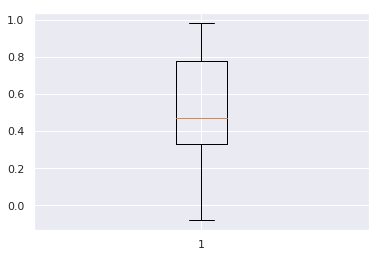

In [15]:
plt.boxplot(scores)

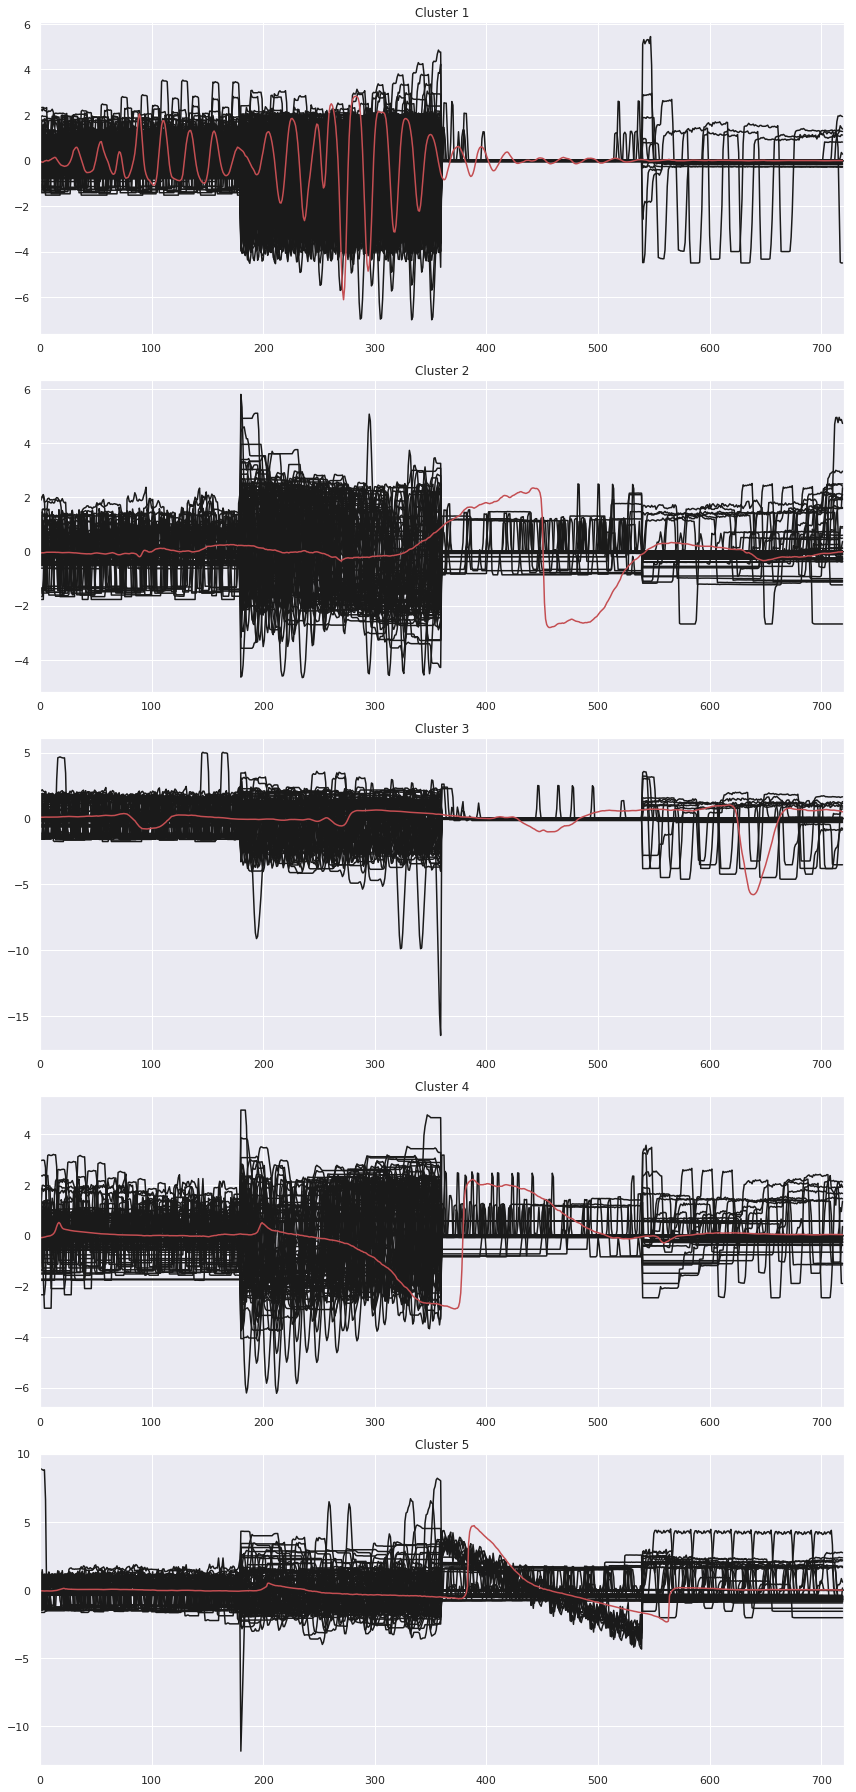

In [18]:
plot_data(ks, X_train[:500], y_pred[:500], sz, ks.n_clusters, centroid=True)

In [22]:
sz = X_train.shape[1]
gak_km = GlobalAlignmentKernelKMeans(n_clusters=5, 
                                     sigma=sigma_gak(X_train[:500]), 
                                     n_init=10, verbose=True)
y_pred = gak_km.fit_predict(X_train[:500])

KeyboardInterrupt: 

In [ ]:
plot_data(gak_km, X_train, y_pred, sz, gak_km.n_clusters)

In [ ]:
scores_km_shifted = compute_scores(gak_km, X_train, y_pred, centroid=False)

In [ ]:
plt.boxplot(scores_km_shifted)

In [24]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

seed = 0
numpy.random.seed(seed)

sdtw_km = TimeSeriesKMeans(n_clusters=5, metric="softdtw", metric_params={"gamma_sdtw": .01},
                           verbose=True, random_state=seed)
y_pred = sdtw_km.fit_predict(X_train[:500])

54456.588 --> 7865.087 --> 7215.789 --> 7045.430 --> 6990.422 --> 6983.651 --> 6980.386 --> 6980.482 --> 6982.775 --> 6983.785 --> 6981.188 --> 6981.058 --> 6982.928 --> 6981.183 --> 6979.508 --> 6980.243 --> 6979.764 --> 6980.026 --> 6979.867 --> 6974.549 --> 6971.708 --> 6971.812 --> 6970.077 --> 6970.283 --> 6969.268 --> 6969.370 --> 6968.867 --> 6968.911 --> 6968.644 --> 6969.479 --> 6968.905 --> 6968.819 --> 6968.556 --> 6968.624 --> 6968.257 --> 6968.512 --> 6968.093 --> 6968.492 --> 6968.128 --> 6968.297 --> 6968.049 --> 6968.545 --> 6968.066 --> 6968.119 --> 6967.870 --> 6967.866 --> 6967.772 --> 6967.740 --> 6967.764 --> 6967.700 --> 


In [26]:
scores_kmeans_softdtw = compute_scores(sdtw_km, X_train[:500], y_pred[:500], centroid=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f07229f8828>,
 'caps': [<matplotlib.lines.Line2D at 0x7f07229f8f28>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f07229f86a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0722a00668>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0722a009e8>],
 'means': []}

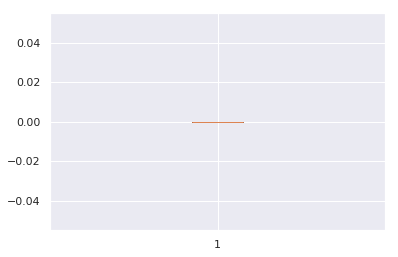

In [28]:
plt.boxplot(scores_kmeans_softdtw)

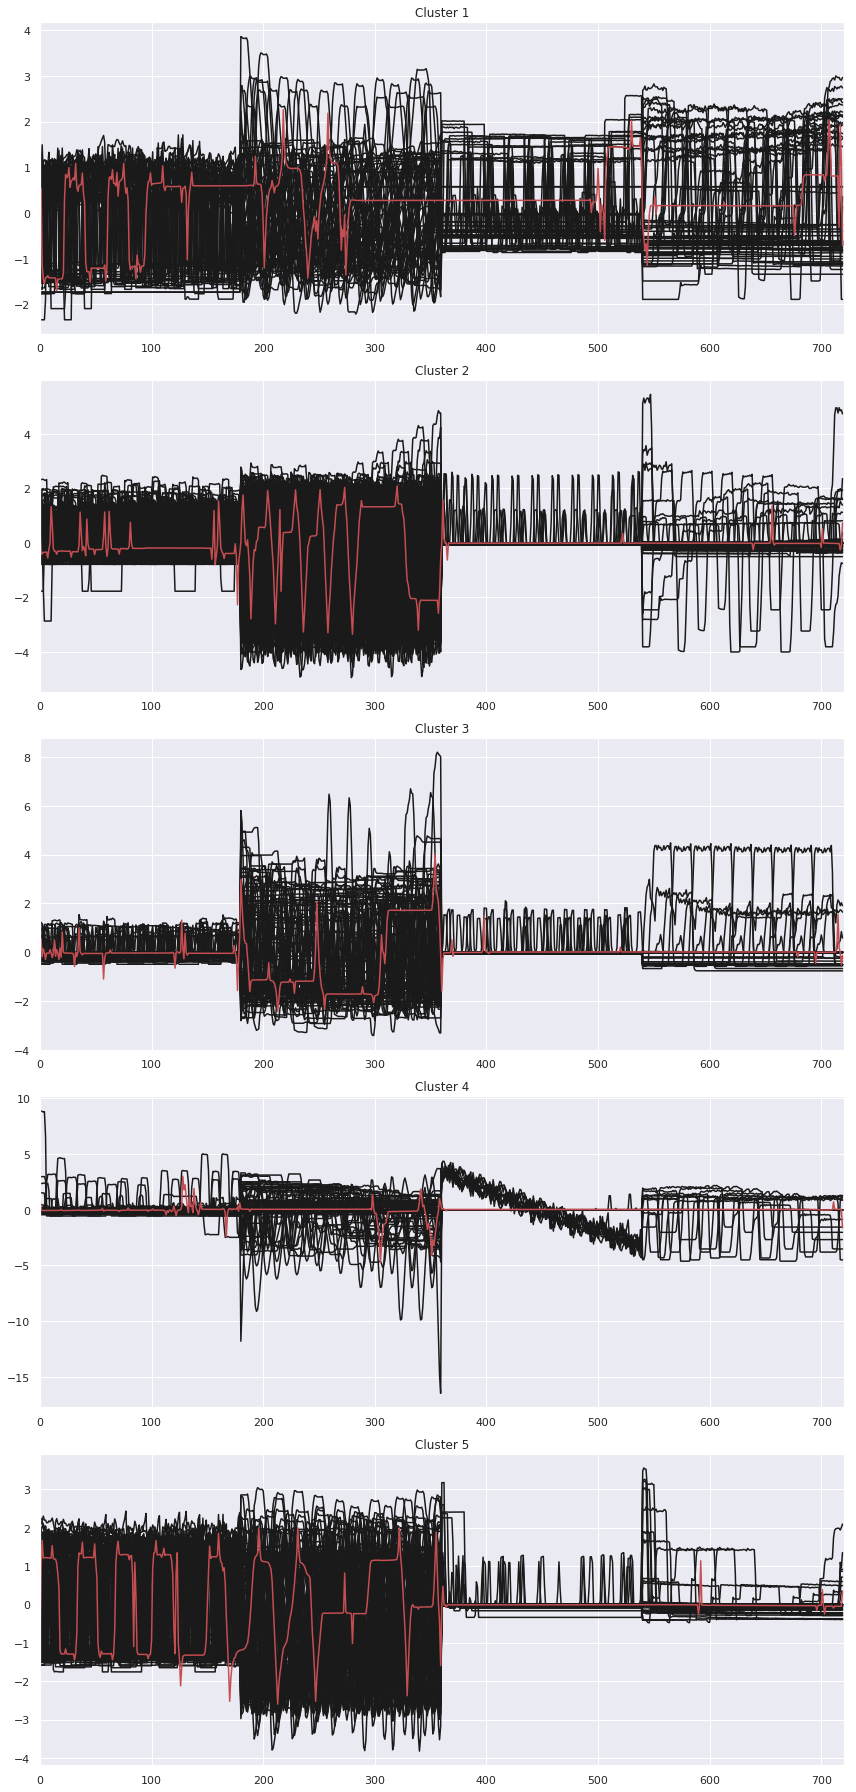

In [29]:
plot_data(sdtw_km, X_train[:500], y_pred[:500], sz, sdtw_km.n_clusters, centroid=True)

In [ ]:
from tslearn import metrics
import pandas as pd

def create_distances(X_train):
    dataset_scaled = X_train.reshape((X_train.shape[0], X_train.shape[1]))
    distances_list = list()
    
    for n in np.arange(len(X_train)):
        envelope_down, envelope_up = metrics.lb_envelope(dataset_scaled[n], radius=3)

        for i in np.arange(len(X_train)):
            if i != n:
                distance = metrics.lb_keogh(dataset_scaled[i], envelope_candidate=(envelope_down, envelope_up))
                distances_list.append((n,i,distance))

    distances_df = pd.DataFrame(distances_list, columns=['series1','series2', 'value'])
    
    return distances_df

In [ ]:
distances_df = create_distances(X_train[:500])

In [ ]:
import numpy as np
from sklearn import mixture

x = np.array(distances_df['value'])
clf = mixture.GaussianMixture(n_components=20, covariance_type='full')
clf.fit(x.reshape(-1,1))

labels = clf.predict(x.reshape(-1,1))
x_axis = np.array(distances_df['series1'])
y = np.array(distances_df['series2'])


In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(x, y, c=labels, s=10, cmap='viridis');

In [ ]:
scores_gmm = compute_scores(clf, X_train[:500], labels[:500], centroid=False)

In [ ]:
plt.boxplot(scores_gmm)

In [ ]:
np.mean(scores_gmm)